In [1]:
# import dependencies
from google.colab import auth
auth.authenticate_user()
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(font_scale=1.0)
try:
  import pandasql as ps
except:
  !pip -q install pandasql
  import pandasql as ps
import time

**Train Section**

In [2]:
# train the model using data from the entire 2020 (whiskey liqueur bottles_sold)
%%bigquery --project double-catfish-305605 whiskeyliqueur2020
SELECT date, category_name, SUM(bottles_sold) AS bottles_sold FROM `bigquery-public-data.iowa_liquor_sales.sales` WHERE date BETWEEN '2020-01-01' AND '2020-12-31' AND category_name = 'Whiskey Liqueur' GROUP BY date, category_name ORDER BY date

In [3]:
whiskeyliqueur2020.head()

,date,category_name,bottles_sold
0,2020-01-02,Whiskey Liqueur,10916
1,2020-01-03,Whiskey Liqueur,16930
2,2020-01-06,Whiskey Liqueur,12410
3,2020-01-07,Whiskey Liqueur,11985
4,2020-01-08,Whiskey Liqueur,9555


In [4]:
whiskeyliqueur2020.tail()

,date,category_name,bottles_sold
256,2020-12-26,Whiskey Liqueur,17656
257,2020-12-28,Whiskey Liqueur,16606
258,2020-12-29,Whiskey Liqueur,19868
259,2020-12-30,Whiskey Liqueur,11970
260,2020-12-31,Whiskey Liqueur,19170


In [5]:
print('There are a total of {} days transactions that involved Whiskey Liqueur in the year 2020'.format(len(whiskeyliqueur2020)))

There are a total of 261 days transactions that involved Whiskey Liqueur in the year 2020


In [6]:
# check missing data
print(whiskeyliqueur2020.isnull().sum())

date             0
category_name    0
bottles_sold     0
dtype: int64


In [7]:
whiskeyliqueur2020 = whiskeyliqueur2020.iloc[:,::2]

Text(0, 0.5, 'Bottles')

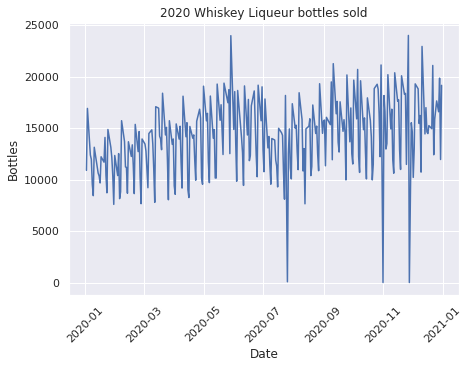

In [8]:
plt.figure(figsize=(7,5))
plt.title('2020 Whiskey Liqueur bottles sold')
sns.lineplot(data=whiskeyliqueur2020, x="date", y="bottles_sold")
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Bottles')

In [9]:
# prepare the train data to use by the model
train_bottl = np.array(whiskeyliqueur2020.iloc[:,1:])
train_data = np.reshape(train_bottl, -1)

T = 10 # The Timestep used is 10, which means to use the last 10 days of bottles_sold value to forecast the bottles_sold of the next day
X_train = []
Y_train = []
for t in range(len(train_data) - T):
    x = train_data[t:t+T]
    X_train.append(x)
    y = train_data[t+T]
    Y_train.append(y)

X_train = np.array(X_train).reshape(-1, T)
X_train = torch.from_numpy(X_train.astype(np.float32))
Y_train = np.array(Y_train).reshape(-1, 1)
Y_train = torch.from_numpy(Y_train.astype(np.float32))

In [10]:
# the model
model = nn.Linear(T, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [11]:
# train the model
loss_history = []

for epoch in range(5000): 
    t0 = time.time()
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss = loss.item()
    loss_history.append(loss)

    print('----------------------------------------------------------------')
    print('epoch: ', (epoch + 1))   
    print('----------------------------------------------------------------')
    print('training loss: {:.4f}'.format(loss))
    print('epoch time: {:.4f} seconds'.format(time.time() - t0))

Streaming output truncated to the last 5000 lines.
----------------------------------------------------------------
epoch:  4001
----------------------------------------------------------------
training loss: 10414336.0000
epoch time: 0.0017 seconds
----------------------------------------------------------------
epoch:  4002
----------------------------------------------------------------
training loss: 10414317.0000
epoch time: 0.0042 seconds
----------------------------------------------------------------
epoch:  4003
----------------------------------------------------------------
training loss: 10414296.0000
epoch time: 0.0022 seconds
----------------------------------------------------------------
epoch:  4004
----------------------------------------------------------------
training loss: 10414276.0000
epoch time: 0.0037 seconds
----------------------------------------------------------------
epoch:  4005
----------------------------------------------------------------
training l

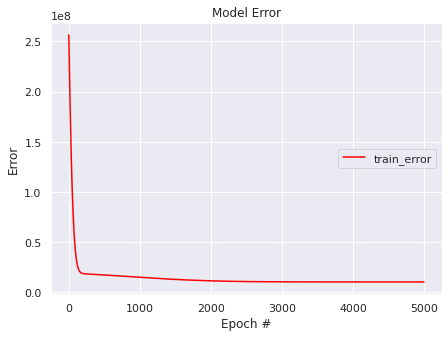

In [12]:
plt.figure(figsize=(7,5))
plt.title('Model Error')
plt.plot(loss_history, color = 'red')
plt.ylabel('Error')
plt.xlabel('Epoch #')
plt.legend(['train_error'], loc = 'center right')

**Test section**

In [13]:
# select data from january 2021 to test the model (the last 10 days of 2020 to forecast the first day of january 2021)
%%bigquery --project double-catfish-305605 whiskeyliqueur_jan2021
SELECT date, category_name, SUM(bottles_sold) AS bottles_sold FROM `bigquery-public-data.iowa_liquor_sales.sales` WHERE date BETWEEN '2020-12-18' AND '2021-01-31' AND category_name = 'Whiskey Liqueur' GROUP BY date, category_name ORDER BY date

In [14]:
whiskeyliqueur_jan2021.head()

,date,category_name,bottles_sold
0,2020-12-18,Whiskey Liqueur,15259
1,2020-12-21,Whiskey Liqueur,14961
2,2020-12-22,Whiskey Liqueur,21102
3,2020-12-23,Whiskey Liqueur,12429
4,2020-12-24,Whiskey Liqueur,15888


In [15]:
whiskeyliqueur_jan2021.tail()

,date,category_name,bottles_sold
25,2021-01-25,Whiskey Liqueur,16077
26,2021-01-26,Whiskey Liqueur,13040
27,2021-01-27,Whiskey Liqueur,13210
28,2021-01-28,Whiskey Liqueur,10770
29,2021-01-29,Whiskey Liqueur,16438


In [16]:
print('There are a total of {} days of transactions that involved Whiskey Liqueur in January 2021'.format(len(whiskeyliqueur_jan2021)-10))

There are a total of 20 days of transactions that involved Whiskey Liqueur in January 2021


In [17]:
# check missing data
print(whiskeyliqueur_jan2021.isnull().sum())

date             0
category_name    0
bottles_sold     0
dtype: int64


In [18]:
# prepare the test data to use by the model
whiskeyliqueur_jan2021 = whiskeyliqueur_jan2021.iloc[:,::2]
test_bottl = np.array(whiskeyliqueur_jan2021.iloc[:,1:])
test_data = np.reshape(test_bottl, -1)

T = 10
X_test = []
Y_test = []
for t in range(len(test_data) - T):
    x = test_data[t:t+T]
    X_test.append(x)
    y = test_data[t+T]
    Y_test.append(y)
    
X_test = np.array(X_test).reshape(-1, T)
X_test = torch.from_numpy(X_test.astype(np.float32))
Y_test = np.array(Y_test).reshape(-1, 1)
Y_test = torch.from_numpy(Y_test.astype(np.float32))

In [19]:
# multi-step forecast
test_pred = []
X_last_test = X_test[T]

for i in range(len(Y_test)):
    input_ = X_last_test.view(1, -1)
    pred = model(input_)
    test_pred.append(pred.item())
    X_last_test = torch.cat((X_last_test[1:], pred[0]))

multi_step_forecast = whiskeyliqueur_jan2021.iloc[10:]
multi_step_forecast = multi_step_forecast.reset_index(drop=True)
multi_step_forecast['bottles_sold_forecast'] = pd.DataFrame(test_pred)
multi_step_forecast['forecast_error'] = [multi_step_forecast.bottles_sold[i] - multi_step_forecast.bottles_sold_forecast[i] for i, x in enumerate(multi_step_forecast.bottles_sold)]

In [20]:
multi_step_forecast

,date,bottles_sold,bottles_sold_forecast,forecast_error
0,2021-01-04,15674,15909.690430,-235.690430
1,2021-01-05,13164,13140.139648,23.860352
2,2021-01-06,9525,12876.492188,-3351.492188
3,2021-01-07,12812,13547.468750,-735.468750
4,2021-01-08,16266,15503.001953,762.998047
5,2021-01-11,17658,15357.707031,2300.292969
6,2021-01-12,12636,13814.835938,-1178.835938
7,2021-01-13,14651,13539.932617,1111.067383
8,2021-01-14,12029,13622.515625,-1593.515625
9,2021-01-15,15468,15392.927734,75.072266


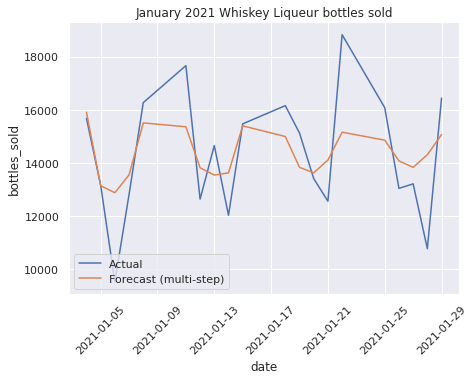

In [21]:
plt.figure(figsize=(7,5))
plt.title('January 2021 Whiskey Liqueur bottles sold')
sns.lineplot(data=multi_step_forecast, x="date", y="bottles_sold")
sns.lineplot(data=multi_step_forecast, x="date", y="bottles_sold_forecast")
plt.xticks(rotation=45)
plt.legend(['Actual','Forecast (multi-step)'], loc = 'lower left')